In [176]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from fancyimpute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')

In [177]:
# Load the data
data = pd.read_csv('payment-practicesold.csv')

In [178]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

In [179]:
# assigning types of features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [180]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,10381,42.852425
Average time to pay,2448,10.105263
% Invoices paid within 30 days,2448,10.105263
% Invoices paid between 31 and 60 days,2448,10.105263
% Invoices paid later than 60 days,2448,10.105263
% Invoices not paid within agreed terms,2405,9.927761
Shortest (or only) standard payment period,2405,9.927761
Longest standard payment period,9919,40.945304
Maximum contractual payment period,2405,9.927761
Payment terms have changed,2405,9.927761


Handling missing data

In [181]:
data = data.dropna(subset=['E-Invoicing offered'])

In [182]:
data['Payments made in the reporting period'].fillna(0, inplace=True)
data['Suppliers notified of changes'].fillna(1, inplace=True)

In [183]:
for col in numerical_features:
    data[col] = data[col].fillna(data[col].mean())

In [184]:
mice_imputer = IterativeImputer()
data_imputed = mice_imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
data = data_imputed

In [185]:
#missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


In [186]:
n = 5

In [187]:
percentile = []
for per in range(n):
    percentile.append(np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 90-(per*10)))
percentile

[68.0, 51.0, 40.0, 31.0, 24.5]

In [188]:
flags = []
for i in range(n):
    flag = []
    for j in data['% Invoices not paid within agreed terms']:
        if j > percentile[i]: flag.append(1)
        else: flag.append(0)
    flags.append(flag)
data.drop('% Invoices not paid within agreed terms',axis=1,inplace=True)

In [189]:
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(n):
    a,b,c,d = train_test_split(data, flags[i], test_size=0.3, random_state=42)
    X_train.append(a)
    X_test.append(b)
    y_train.append(c)
    y_test.append(d)


In [190]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()
for i in range(n):
    X_train[i], y_train[i] = oversampler.fit_resample(X_train[i], y_train[i])

In [191]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# XGBoost Model
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

In [192]:
y_pred = []
y_pred_proba = []
model = []
for i in range(n):
    xgb_clf = XGBClassifier(**params)
    xgb_clf.fit(X_train[i], y_train[i])
    model.append(xgb_clf)
    y_pred.append(xgb_clf.predict(X_test[i]))
    y_pred_proba.append(xgb_clf.predict_proba(X_test[i])[:, 1])
    

In [193]:
f_score = []
auc_list = []
accuracy = []
fpr = []
tpr = []
thresholds = []
for i in range(n):
    accuracy.append(accuracy_score(y_test[i], y_pred[i]))
    f_score.append(f1_score(y_test[i], y_pred[i]))
    fpr_, tpr_, thresholds_ = roc_curve(y_test[i], y_pred_proba[i])
    fpr.append(fpr_)
    tpr.append(tpr_)
    thresholds.append(thresholds_)
    auc_list.append(auc(fpr[i], tpr[i]))

Comparing the models

In [194]:
results = {
    'Risk Proportion': [str((i+1)*10)+'%' for i in range(n)],
    'Accuracy': accuracy,
    'F1 Score': f_score,
    'AUC': auc_list
}

results_df = pd.DataFrame(results)
results_df


,Risk Proportion,Accuracy,F1 Score,AUC
0,10%,0.861595,0.433750,0.835206
1,20%,0.800794,0.550345,0.827700
2,30%,0.760006,0.619520,0.815352
3,40%,0.742744,0.688840,0.815451
4,50%,0.750382,0.752948,0.827319


Receiver Operating Characteristic (ROC) Curves

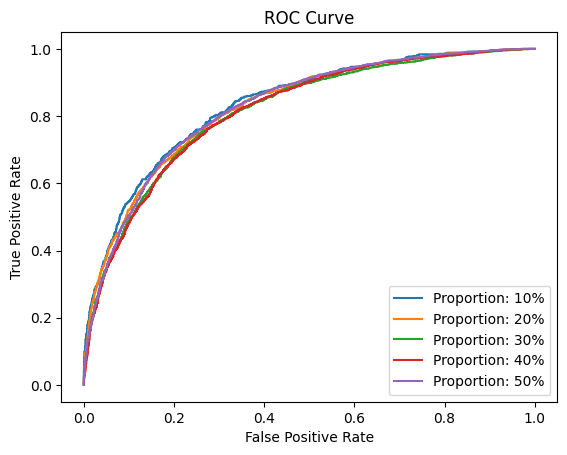

In [195]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Define the proportions
proportions = [0.1, 0.3, 0.5, 0.7, 0.9]

# Iterate over the proportions
for i in range(n):
    # Plot the ROC curve
    plt.plot(fpr[i], tpr[i], label=f'Proportion: {str((i+1)*10)}%')

# Set the labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Show the plot
plt.show()
